# Flowers classification (Preprocessing without augmentation)

The dataset contains 3670 images of flowers belonging to five classes (daisy, dandelion, roses, sunflowers, and tulips).

The workflow will be:

- Different CNN architectures;
- Train set on its own, with/without augmentation;
- CNN VS ML algorithm --> the best?
- Manifold learning prior to NN


## Data loading

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
from tensorflow.keras.applications import VGG16

In [2]:
from google.colab import drive
import tarfile

drive.mount('/content/gdrive')
# Path to your .tgz file
file_path = 'gdrive/My Drive/Colab Notebooks/flower_photos.tgz'

# Extract the contents
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')

Mounted at /content/gdrive


Load train and validation data from folder.

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
#from tensorflow.keras.layers.experimental import preprocessing

batch_size = 32
img_height = 224
img_width = 224

# Load train data
train_dataset = keras.utils.image_dataset_from_directory(
    'flower_photos',
    image_size=(img_height, img_width),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=1,
    shuffle=True
)

# Load validation data
validation_dataset = keras.utils.image_dataset_from_directory(
    'flower_photos',
    image_size=(img_height, img_width),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=1,
    shuffle=True
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [4]:
class_names = train_dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Preprocessing

In [5]:
# Normalize the pixels --> rescale

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [6]:
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


#

# Neural Network

We choose to work with the VGG-16 network. The VGG-16 model is a convolutional neural network (CNN) architecture that was proposed by the Visual Geometry Group (VGG) at the University of Oxford. It is characterized by its depth, consisting of 16 layers, including 13 convolutional layers and 3 fully connected layers. VGG-16 is renowned for its simplicity and effectiveness, as well as its ability to achieve strong performance on various computer vision tasks, including image classification and object recognition. The model’s architecture features a stack of convolutional layers followed by max-pooling layers, with progressively increasing depth. This design enables the model to learn intricate hierarchical representations of visual features, leading to robust and accurate predictions. Despite its simplicity compared to more recent architectures, VGG-16 remains a popular choice for many deep learning applications due to its versatility and excellent performance.

The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) is an annual competition in computer vision where teams tackle tasks including object localization and image classification. VGG16, proposed by Karen Simonyan and Andrew Zisserman in 2014, achieved top ranks in both tasks, detecting objects from 200 classes and classifying images into 1000 categories. (source: https://www.geeksforgeeks.org/vgg-16-cnn-model/)

Epoch 1/20
92/92 [==============================] - 39s 300ms/step - loss: 8.2038 - accuracy: 0.6638 - val_loss: 0.7428 - val_accuracy: 0.7793
Epoch 2/20
92/92 [==============================] - 17s 176ms/step - loss: 0.8376 - accuracy: 0.7708 - val_loss: 0.7280 - val_accuracy: 0.7766
Epoch 3/20
92/92 [==============================] - 17s 180ms/step - loss: 0.6871 - accuracy: 0.8072 - val_loss: 0.7446 - val_accuracy: 0.8215
Epoch 4/20
92/92 [==============================] - 16s 169ms/step - loss: 0.5305 - accuracy: 0.8304 - val_loss: 0.7423 - val_accuracy: 0.7984
Epoch 5/20
23/23 [==============================] - 3s 131ms/step - loss: 0.7280 - accuracy: 0.7766
Validation accuracy: 0.78


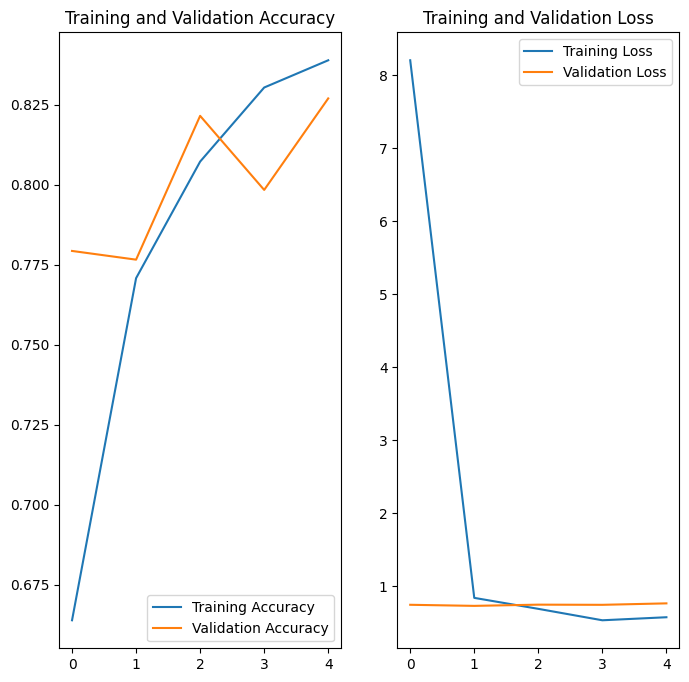

In [8]:
# Load the VGG-16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (wanna try non-freezed?)
base_model.trainable = False

# Build the model
model = models.Sequential([
    #data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation accuracy: {accuracy:.2f}")


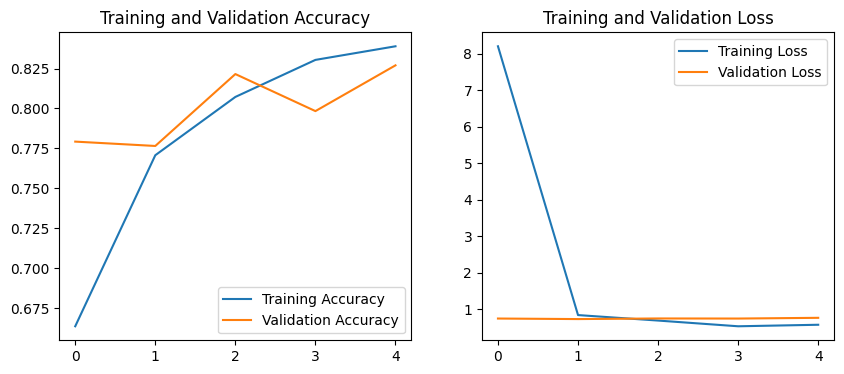

In [9]:
# Plot training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()